# Анализ шоколадных батончиков

Оглавление
1. [Введение](#introduction)
2. [Предобработка](#preprocessing)
3. [Анализ данных](#data-analysis)  
  3.1 [Влияние компании и количества выпускаемых ею батончиков на рейтинг](#compnum-rating)    
  3.2 [Влияние вида шоколада на рейтинг](#species-rating)   
  3.3 [Регионы, где производят лучшие батончики. Влияние крупных стран-производителей на рейтинг](#comploc-rating)  
  3.4 [Где растут лучшие какао-бобы. Влияние места произрастания бобов на рейтинг](#continent-rating)  
  3.5 [Влияние сорта какао-бобов на рейтинг](#bean-rating)  
  3.6 [Корреляция между процентным содержанием какао и рейтингом](#cocoa-rating-corr)  
  3.7 [Связь года публикации обзора и других показателей](#year-corr)  
  3.8 [Построение модели линейной регрессии](#model)  
4. [Выводы](#conclusion)  

## 1. Введение <a id="introduction"></a> 

### Цель анализа  
Цель этого проекта - определить, какие факторы делают шоколадные батончики высоко оцениваемыми и оказывают наибольшее влияние на их рейтинг.

### Описание данных  
Данные взяты из набора <a href="https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings">Chocolate Bar Ratings</a>. Он содержит информацию о более 1700 отдельных шоколадных батончиков:
* **company** - название компании.
* **species** - вид шоколада.
* **REF** - значение, связанное с временем внесения отзыва в базу данных.
* **review_year** - год публикации обзора.
* **cocoa_percentage** - процент содержания какао в батончике.
* **company_location** - страна - производитель.
* **rating** - рейтинг:  
    * 5 - Elite (лучше чем обычно).    
    * 4 - Premium (хорошо развитый вкус, присутствует характер и стиль).    
    * 3 - от удовлитворительного (3.0 - Satisfactory) до хорошего, качественного (3.75 - Praiseworthy).    
    * 2 - Disappointing (приемлемый, но содержит по крайней мере один существенный недостаток).   
    * 1= Unpleasant (невкусный, несъедобный).    
* **bean_type** - сорт какао-боба.
* **country** - широкий географический регион происхождения какао-бобов. 


### План  
1. Предобработка данных.
2. Анализ влияния компании и количества выпускаемых ею батончиков на рейтинг.
3. Оценка зависимости рейтинга от вида шоколада.
4. Поиск регионов, где производят лучшие батончики. Анализ влияния крупных стран-производителей на рейтинг.
5. Определение места, где растут лучшие какао-бобы. Влияние на рейтинг.  
6. Влияние сорта какао-бобов на рейтинг.  
7. Корреляция процента какао с рейтингом.
8. Связь года публикации обзора с другими переменными.
9. Построение модели линейной регрессии.

## 2. Предобработка <a id="preprocessing"></a>

Отобразим данные:

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("flavors_of_cacao.csv")
columns = ["company", "species", "REF", "review_year", "cocoa_percentage", "company_location", "rating", "bean_type", "country"]
df.columns = columns
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'flavors_of_cacao.csv'

Типы данных в столбцах:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1795 non-null   object 
 1   species           1795 non-null   object 
 2   REF               1795 non-null   int64  
 3   review_year       1795 non-null   int64  
 4   cocoa_percentage  1795 non-null   object 
 5   company_location  1795 non-null   object 
 6   rating            1795 non-null   float64
 7   bean_type         1794 non-null   object 
 8   country           1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


Все типы данных, кроме cocoa_percentage, нас устраивают.   
Для удобства переведем его в числовой тип:

In [ ]:
df["cocoa_percentage"] = df["cocoa_percentage"].str[0:-1].astype("float64")/100
df["cocoa_percentage"].dtype


dtype('float64')

Прверим наличие дубликатов:

In [ ]:
df[df.duplicated()]

,company,species,REF,review_year,cocoa_percentage,company_location,rating,bean_type,country


Дабликаты отсутствуют.  
  
Изучим пропущенные значения.   
В исходной таблице уже видно, что в столбце bean_type часть данных отсутствует. Попробуем поискать и другие пропуски и подсчитать их.

In [ ]:

df.loc[0, "bean_type"]

'\xa0'

In [ ]:
# Заменим строки, которые содержат только пустые значения, пробелы или '\xa0' на NaN:
df.replace('', np.nan, inplace=True)
df.replace(' ', np.nan, inplace=True) 
df.replace('\xa0', np.nan, inplace=True) 
df[df.isna().any(axis=1)].loc[:5:]

,company,species,REF,review_year,cocoa_percentage,company_location,rating,bean_type,country
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,NaN,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,NaN,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,NaN,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,NaN,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,NaN,Peru


In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['bean_type', 'country'], dtype='object')

In [ ]:
int(df["bean_type"].isna().sum()), int(df["country"].isna().sum())

(888, 74)

Пропуски обнаружены в столбцах bean_type (888 шт.) и country (74 шт.):   
* в bean_type оставим их как есть;  
* в country - заменим на Unknown.  

In [ ]:
df["country"] = df["country"].fillna("Unknown")
int(df["country"].isna().sum())

0

Проверим корректность заполнения числовых данных:  
* review_year - не больше текущего года;
* cocoa_percentage - от 0 до 1;
* rating - от 1 до 5.

In [ ]:
current_year = pd.to_datetime('today').year
len(df[df["review_year"] > current_year])

0

In [ ]:
len(df[(df["cocoa_percentage"] < 0) | (df["cocoa_percentage"] > 1)])

0

In [ ]:
len(df[(df["rating"] < 1) | (df["rating"] > 5)])

0

Числовые данные заполнены корректно.  
Посмотрим, в какие годы были опубликованы данные (столбец review_year):

In [ ]:
df.groupby("review_year").size()

review_year
2006     72
2007     77
2008     93
2009    123
2010    111
2011    165
2012    195
2013    184
2014    247
2015    285
2016    219
2017     24
dtype: int64

Представленные данные охватывают 2006-2017 годы.

Проверим некоторые столбцы со строковыми данными:
* не должно быть орфографических ошибок;
* когда в ячейке несколько значений, они должны быть в виде списка. 

**Стобец country**

In [ ]:
df["country"].unique()

array(['Sao Tome', 'Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama',
       'Madagascar', 'Brazil', 'Ecuador', 'Colombia', 'Burma',
       'Papua New Guinea', 'Bolivia', 'Fiji', 'Mexico', 'Indonesia',
       'Trinidad', 'Vietnam', 'Nicaragua', 'Tanzania',
       'Dominican Republic', 'Ghana', 'Belize', 'Unknown', 'Jamaica',
       'Grenada', 'Guatemala', 'Honduras', 'Costa Rica',
       'Domincan Republic', 'Haiti', 'Congo', 'Philippines', 'Malaysia',
       'Dominican Rep., Bali', 'Venez,Africa,Brasil,Peru,Mex', 'Gabon',
       'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico', 'Uganda',
       'Martinique', 'Sao Tome & Principe', 'Vanuatu', 'Australia',
       'Liberia', 'Ecuador, Costa Rica', 'West Africa', 'Hawaii',
       'St. Lucia', 'Cost Rica, Ven', 'Peru, Madagascar',
       'Venezuela, Trinidad', 'Trinidad, Tobago',
       'Ven, Trinidad, Ecuador', 'South America, Africa', 'India',
       'Africa, Carribean, C. Am.', 'Tobago', 'Ven., Indonesia, Ecuad.',
       'Trinidad-Tob

Видно, что в некоторых ячейках может быть несколько стран, а где-то штаты или целые континенты. Также написание может отличаться.   
Работать с такими данными неудобно.  
Чтобы решить эту задачу, создадим новый столбец с континентом. Для этого напишем словарь соответствий, а также объединим континенты в списки.

In [ ]:
# Словарь стран и регионов -> континенты
continent_mapping = {
    # Южная Америка
    "Venezuela": "South America",
    "Ven": "South America",
    "Venez": "South America",
    "Ven.": "South America",
    "Peru": "South America",
    "Brazil": "South America",
    "Brasil": "South America",
    "Ecuador": "South America",
    "Ecuad": "South America",
    "Ecuad.": "South America",
    "Colombia": "South America",
    "Bolivia": "South America",
    "South America": "South America",
    "Suriname": "South America",
    # Центральная Америка (без Карибских островов)
    "Panama": "Central America",
    "Mexico": "Central America",
    "Nicaragua": "Central America",
    "Belize": "Central America",
    "Guatemala": "Central America",
    "Honduras": "Central America",
    "Costa Rica": "Central America",
    "El Salvador": "Central America",
    "United States": "Central America",  
    "Hawaii": "Central America",       
    # Карибы
    "Cuba": "Caribbean",
    "Dominican Republic": "Caribbean",
    "Domincan Republic": "Caribbean",
    "Dominican Rep": "Caribbean",
    "Dominican Rep.": "Caribbean",
    "Domin. Rep": "Caribbean",
    "Dom. Rep": "Caribbean",
    "Dom. Rep.": "Caribbean",
    "D.R.": "Caribbean",
    "DR": "Caribbean",
    "Jamaica": "Caribbean",
    "Grenada": "Caribbean",
    "Haiti": "Caribbean",
    "Trinidad": "Caribbean",
    "Tobago": "Caribbean",
    "Trinidad-Tobago": "Caribbean",
    "Puerto Rico": "Caribbean",
    "Martinique": "Caribbean",
    "St. Lucia": "Caribbean",
    "Carribean": "Caribbean",
    "Tri": "Caribbean",
    "Gre": "Caribbean",
    "Jam": "Caribbean",
    # Африка
    "Sao Tome": "Africa",
    "Togo": "Africa",
    "Madagascar": "Africa",
    "Ghana": "Africa",
    "Tanzania": "Africa",
    "Congo": "Africa",
    "Gabon": "Africa",
    "Ivory Coast": "Africa",
    "Uganda": "Africa",
    "Liberia": "Africa",
    "West Africa": "Africa",
    "Nigeria": "Africa",
    "Cameroon": "Africa",
    "Sao Tome & Principe": "Africa",
    "Principe": "Africa",
    "Africa": "Africa",
    "Mad": "Africa",
    "Mad.": "Africa",
    # Азия
    "Burma": "Asia",
    "Vietnam": "Asia",
    "Indonesia": "Asia",
    "Philippines": "Asia",
    "Malaysia": "Asia",
    "Sri Lanka": "Asia",
    "India": "Asia",
    "Java": "Asia",
    "Bali": "Asia",
    # Океания
    "Papua New Guinea": "Oceania",
    "Fiji": "Oceania",
    "Vanuatu": "Oceania",
    "Australia": "Oceania",
    "Solomon Islands": "Oceania",
    "Samoa": "Oceania",
    "PNG": "Oceania",
    # Неизвестно
    "Unknown": "Unknown",
    # Специфические случаи
    "Peru(SMartin,Pangoa,nacional)": "South America",
    "Central and S. America": "Central America, South America",
    "C. Am.": "Central America",
    "Cost Rica, Ven": "Central America, South America"
}

In [ ]:
# Функция преобразования строки в список континентов
def to_continents(country_str):
    # Обработаем отсутствующие значения
    if not isinstance(country_str, str):
        return [country_str]
    
    # Убираем уточнения в скобках
    country_str = re.sub(r"\(.*?\)", "", country_str).strip()
    country_str = country_str.replace("(", "").replace(")", "")
    
    # Разбиваем по разделителям
    locations = re.split(r"[,/&-]\s*|\s+(?=[A-Z])", country_str.strip())
    
    # Преобразуем в континенты
    continents = set() 
    for loc in locations:
        loc = loc.strip()
        if loc:
            continent = continent_mapping.get(loc, "Unknown")
            if continent:
                continents.update([x.strip() for x in continent.split(",") if x.strip()])
    
    # Возвращаем список
    return list(continents) if continents else ["Unknown"]

df['continent'] = df['country'].apply(to_continents)
unique_continents = df['continent'].explode().unique()
unique_continents

array(['Unknown', 'Africa', 'South America', 'Caribbean',
       'Central America', 'Asia', 'Oceania'], dtype=object)

**Столбец company_location**

In [ ]:
df["company_location"].unique(), len(df["company_location"].unique())

(array(['France', 'U.S.A.', 'Fiji', 'Ecuador', 'Mexico', 'Switzerland',
        'Netherlands', 'Spain', 'Peru', 'Canada', 'Italy', 'Brazil',
        'U.K.', 'Australia', 'Wales', 'Belgium', 'Germany', 'Russia',
        'Puerto Rico', 'Venezuela', 'Colombia', 'Japan', 'New Zealand',
        'Costa Rica', 'South Korea', 'Amsterdam', 'Scotland', 'Martinique',
        'Sao Tome', 'Argentina', 'Guatemala', 'South Africa', 'Bolivia',
        'St. Lucia', 'Portugal', 'Singapore', 'Denmark', 'Vietnam',
        'Grenada', 'Israel', 'India', 'Czech Republic',
        'Domincan Republic', 'Finland', 'Madagascar', 'Philippines',
        'Sweden', 'Poland', 'Austria', 'Honduras', 'Nicaragua',
        'Lithuania', 'Niacragua', 'Chile', 'Ghana', 'Iceland', 'Eucador',
        'Hungary', 'Suriname', 'Ireland'], dtype=object),
 60)

Исправим орфографические ошибки:

In [ ]:
df["company_location"] = df["company_location"].replace({  
    "Domincan Republic": "Dominican Republic",  
    "Niacragua": "Nicaragua",  
    "Eucador": "Ecuador",  
    "Amsterdam": "Netherlands"  
})
len(df["company_location"].unique())


57

**Столбец company**

In [ ]:
df["company"].unique()[:50],  df["company"].nunique()

(array(['A. Morin', 'Acalli', 'Adi', 'Aequare (Gianduja)', 'Ah Cacao',
        "Akesson's (Pralus)", 'Alain Ducasse', 'Alexandre',
        'Altus aka Cao Artisan', 'Amano', 'Amatller (Simon Coll)',
        'Amazona', 'Ambrosia', 'Amedei', 'AMMA', 'Anahata', 'Animas',
        'Ara', 'Arete', 'Artisan du Chocolat',
        'Artisan du Chocolat (Casa Luker)', 'Askinosie', 'Bahen & Co.',
        'Bakau', 'Bar Au Chocolat', "Baravelli's", 'Batch', 'Beau Cacao',
        'Beehive', 'Belcolade', 'Bellflower', 'Belyzium', 'Benoit Nihant',
        'Bernachon', 'Beschle (Felchlin)', 'Bisou', 'Bittersweet Origins',
        'Black Mountain', 'Black River (A. Morin)', 'Blanxart',
        'Blue Bandana', 'Bonnat', 'Bouga Cacao (Tulicorp)', 'Bowler Man',
        "Brasstown aka It's Chocolate", 'Brazen', 'Breeze Mill', 'Bright',
        'Britarev', 'Bronx Grrl Chocolate'], dtype=object),
 416)

Орфографических ошибок нет.  
Уникальных компаний очень много. Это значит, что крупных компаний, выпускающих больше одного вида батончика, мало.

**Столбец species**

In [ ]:
df["species"].unique()[:30],  df["species"].nunique()

(array(['Agua Grande', 'Kpime', 'Atsane', 'Akata', 'Quilla', 'Carenero',
        'Cuba', 'Sur del Lago', 'Puerto Cabello', 'Pablino', 'Panama',
        'Madagascar', 'Brazil', 'Equateur', 'Colombie', 'Birmanie',
        'Papua New Guinea', 'Chuao', 'Piura', 'Chanchamayo Province',
        'Bolivia', 'Peru', 'Chulucanas, El Platanal', 'Tumbes, Norandino',
        'Vanua Levu', 'Vanua Levu, Toto-A', 'Vanua Levu, Ami-Ami-CA',
        'Los Rios, Quevedo, Arriba', 'Tabasco',
        'Bali (west), Sukrama Family, Melaya area'], dtype=object),
 1039)

Орфографических ошибок нет.  
Уникальных видов шоколада очень много. Однако некоторые из них используются для разных батончиков разных компаний.

**Столбец bean_type**

In [ ]:
df["bean_type"].unique(), df["bean_type"].nunique()

(array([nan, 'Criollo', 'Trinitario', 'Forastero (Arriba)', 'Forastero',
        'Forastero (Nacional)', 'Criollo, Trinitario',
        'Criollo (Porcelana)', 'Blend', 'Trinitario (85% Criollo)',
        'Forastero (Catongo)', 'Forastero (Parazinho)',
        'Trinitario, Criollo', 'CCN51', 'Criollo (Ocumare)', 'Nacional',
        'Criollo (Ocumare 61)', 'Criollo (Ocumare 77)',
        'Criollo (Ocumare 67)', 'Criollo (Wild)', 'Beniano', 'Amazon mix',
        'Trinitario, Forastero', 'Forastero (Arriba) ASS', 'Criollo, +',
        'Amazon', 'Amazon, ICS', 'EET', 'Blend-Forastero,Criollo',
        'Trinitario (Scavina)', 'Criollo, Forastero', 'Matina',
        'Forastero(Arriba, CCN)', 'Nacional (Arriba)',
        'Forastero (Arriba) ASSS', 'Forastero, Trinitario',
        'Forastero (Amelonado)', 'Trinitario, Nacional',
        'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Criollo (Amarru)'],
       dtype=object),
 40)

Исправим орфографические ошибки и форматирование:

In [ ]:
df["bean_type"] = (df["bean_type"].str
                   .replace('Trinitario, Criollo', 'Criollo, Trinitario')
                   .replace('Criollo, +', 'Criollo')
                   .replace('Trinitario, Forastero', 'Forastero, Trinitario')
                   .replace('Blend-Forastero,Criollo', 'Blend-Forastero, Criollo')
                   .replace('Forastero(Arriba, CCN)', 'Forastero (Arriba, CCN)')
)
df["bean_type"].unique(), df["bean_type"].nunique()

(array([nan, 'Criollo', 'Trinitario', 'Forastero (Arriba)', 'Forastero',
        'Forastero (Nacional)', 'Criollo, Trinitario',
        'Criollo (Porcelana)', 'Blend', 'Trinitario (85% Criollo)',
        'Forastero (Catongo)', 'Forastero (Parazinho)', 'CCN51',
        'Criollo (Ocumare)', 'Nacional', 'Criollo (Ocumare 61)',
        'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)', 'Criollo (Wild)',
        'Beniano', 'Amazon mix', 'Forastero, Trinitario',
        'Forastero (Arriba) ASS', 'Amazon', 'Amazon, ICS', 'EET',
        'Blend-Forastero, Criollo', 'Trinitario (Scavina)',
        'Criollo, Forastero', 'Matina', 'Forastero (Arriba, CCN)',
        'Nacional (Arriba)', 'Forastero (Arriba) ASSS',
        'Forastero (Amelonado)', 'Trinitario, Nacional',
        'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Criollo (Amarru)'],
       dtype=object),
 37)

Всего 37 видов какао-бобов.  
<br>

## 3. Анализ данных <a id="data-analysis"></a> 

Основная задача - определить, какие факторы делают шоколадные батончики высоко оцениваемыми и отражаются на рейтинге в большей степени.   
Для ее решения:  
* Во-первых, узнаем, оказывает ли влияние каждый из факторов на рейтинг.    
Будем использовать однофакторный дисперсионный анализ, корреляцию и другие средства.  
Изучим воздействие всех данных, кроме REF (временная метка, которая не поддается интерпретации).   
* Во-вторых, построим модель линейной регрессии, чтобы оценить степень влияния.  
  
<br>

### 3.1 Влияние компании и количества выпускаемых ею батончиков на рейтинг <a id="compnum-rating"></a> 

Изучим, как компания влияет на рейтинг, с двух сторон:
1. Зависит ли рейтинг от бренда компании?
2. Влияет ли количество различных батончиков, выпускаемых компанией, на рейтинг?

#### 3.1-1 Влияние бренда компании на рейтинг <a id="comp-rating"></a>   
Как правило, от компании к компании средний рейтинг шоколадных батончиков меняется. Убедимся, так ли то.  
Будем учитывать только 9 компаний, производящих наибольшее количество батончиков:

In [ ]:
grouped = df.groupby("company").size()
filtered_groups = grouped[grouped > 19].sort_values(ascending=False)
count_filtered_groups = filtered_groups.count()
filtered_groups.index, count_filtered_groups

(Index(['Soma', 'Bonnat', 'Fresco', 'Pralus', 'A. Morin', 'Domori', 'Arete',
        'Guittard', 'Valrhona'],
       dtype='object', name='company'),
 np.int64(9))

Воспользуемся однофакторным дисперсионным анализом.  
Нулевая гипотеза H₀ звучит так:  
*Для всех крупных брендов рейтинг будет примерно одинаковый. Бренд на рейтинг не влияет.*

In [ ]:
top_9_companies = list(filtered_groups.index)
# Фильтруем данные, оставляя строки только с компаниями из топ-9
df_9_companies = df[df['company'].isin(top_9_companies)]
# Разбиваем на группы по брэндам (groups — это список серий)
groups = []
for brand in top_9_companies:
    group = df_9_companies[df_9_companies['company'] == brand]['rating']  # Берем рейтинг для бренда
    groups.append(group)  # Добавляем в список

# Выполняем анализ
f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 2.477924131801446', 'p-value: 0.013572147259980974')

p_value < 0.05, различия значимые, отклоняем H₀ → бренд влияет на рейтинг (разные компании имеют разные рейтинги). 

**Вывод:**  
От компании к компании средний рейтинг шоколадных батончиков меняется. Иными словами, то, какая у батончика компания, влияет на его рейтинг.  
Фактор "компания" не будет включаться в финальную модель, поскольку различия в средних рейтингах между компаниями естественны. К тому же, производитель, стремясь улучшить батончик, вряд ли будет менять саму компанию.

#### 3.1-2 Влияние количества выпускаемых компанией батончиков на рейтинг <a id="num-rating"></a> 
Разобъем все компании на 3 категории:  
* one_bar - компания выпускает только 1 батончик  
* mid - компания выпускает от 2 до 20 батончиков  
* top_9 - компания выпускает больше 20 батончиков  

 Создадим новый столбец и запишем туда категорию:

In [ ]:
# Считаем количество батончиков для каждой компании
company_counts = df['company'].value_counts()

# Функция для присвоения категории
def assign_category(company):
    count = company_counts.get(company, 0)
    if count == 1:
        return 'one_bar'
    elif 2 <= count <= 20:
        return 'mid'
    elif count > 20:
        return 'top_9'
    else:
        return 'unknown'  # если компании нет

# Создаем новый столбец
df['company_cat'] = df['company'].apply(assign_category)
df.head(5)

,company,species,REF,review_year,cocoa_percentage,company_location,rating,bean_type,country,continent,company_cat
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,NaN,Sao Tome,[Unknown],top_9
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,NaN,Togo,[Africa],top_9
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,NaN,Togo,[Africa],top_9
3,A. Morin,Akata,1680,2015,0.70,France,3.50,NaN,Togo,[Africa],top_9
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,NaN,Peru,[South America],top_9


Вновь воспользуемся однофакторным дисперсионным анализом.  
Нулевая гипотеза H₀:  
*Для всех категорий компаний рейтинг будет примерно одинаковый. Категория на рейтинг не влияет.*

In [ ]:
categories = df['company_cat'].unique()
# Разбиваем на группы по категориям
groups = []
for category in categories:
    group = df[df['company_cat'] == category]['rating']  # Берем рейтинг для категории
    groups.append(group)  # Добавляем в список

#Выполняем анализ
f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 38.21017055078147', 'p-value: 5.618534808921667e-17')

p-value >= 0.05, различий между группами нет, принимаем H₀ → категория на рейтинг не влияет.

**Вывод:**  
Количество выпускаемых компанией батончиков на рейтинг не влияет.  
<br>

### 3.2 Влияние вида шоколада на рейтинг <a id="species-rating"></a> 

Рассмотрим, влияет ли вид шоколада на рейтинг батончиков.  
Будем учитывать только 5 самых популярных видов шоколада:

In [ ]:
grouped = df['species'].value_counts()
filtered_species = grouped[grouped >= 20]
filtered_species

species
Madagascar            57
Peru                  45
Ecuador               42
Dominican Republic    37
Venezuela             21
Name: count, dtype: int64

Нулевая гипотеза H₀ для однофакторного дисперсионного анализа:  
*Для всех популярных видов шоколада рейтинг будет примерно одинаковый. Вид шоколада на рейтинг не влияет.*

In [ ]:
pop_species = list(filtered_species.index)
# Фильтруем данные, оставляя строки только с популярными видами шоколада
df_pop_species = df[df['species'].isin(pop_species)]
# Разбиваем на группы по видам шоколада
groups = []
for species in pop_species:
    group = df_pop_species[df_pop_species['species'] == species]['rating']  # Берем рейтинг для вида шоколада
    groups.append(group)  # Добавляем в список

#Выполняем анализ
f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 4.048685303461329', 'p-value: 0.0035395792730588036')

p_value < 0.05, различия значимые, отклоняем H₀ → вид шоколада влияет на рейтинг.  
<br>
**Вывод:**  
Вид шоколада оказывает влияние на рейтинг батончиков.  
<br>

### 3.3 Регионы, где производят лучшие батончики. Влияние крупных стран-производителей на рейтинг <a id="comploc-rating"></a>     
Узнаем, в каких регионах производят батончики с самым высоким рейтингом, а также, влияет ли место производства на рейтинг. 

#### 3.3-1 Где производят лучшие батончики <a id="best-beans-manufacturer"></a>  

Рассмотрим два аспекта: определим страну с самыми высокооцененными батончиками, а также страну с наибольшим средним рейтингом среди всех произведенных батончиков.   
Чтобы узнать страну-производителя лучших батончиков, отсортируем таблицу по рейтингу:

In [ ]:
df.sort_values(by="rating", ascending=False).head()

,company,species,REF,review_year,cocoa_percentage,company_location,rating,bean_type,country,continent,company_cat
86,Amedei,Toscano Black,40,2006,0.70,Italy,5.0,Blend,Unknown,[Unknown],mid
78,Amedei,Chuao,111,2007,0.70,Italy,5.0,Trinitario,Venezuela,[South America],mid
17,A. Morin,Chuao,1015,2013,0.70,France,4.0,Trinitario,Venezuela,[South America],top_9
436,Claudio Corallo,Terreiro Velho P.,227,2008,0.75,Sao Tome,4.0,Forastero,Sao Tome & Principe,"[Africa, Unknown]",mid
311,Cacao Sampaka,Papua,523,2010,0.71,Spain,4.0,NaN,Papua New Guinea,[Unknown],mid


Лучшие батончики производят в Италии.

Теперь посчитаем средний рейтинг:

In [ ]:
df.groupby("company_location")["rating"].mean().reset_index().sort_values(by="rating", ascending=False).head()

,company_location,rating
7,Chile,3.750000
33,Netherlands,3.500000
37,Philippines,3.500000
23,Iceland,3.416667
55,Vietnam,3.409091


По рейтингу батончиков в среднем лучшие в Чили.

**Вывод:**  
* Самые лучшие батончики производят в Италии.   
* По средней оценке всех батончиков - лучшие в Чили.

#### 3.3-2 Влияние крупных стран-производителей на рейтинг

Выясним, влияет ли страна-производитель на рейтинг.  
Будем учитывать только те страны, где производится от 20 разных батончиков:

In [ ]:
locations = df["company_location"].value_counts()
top_locations = list(locations[locations >= 20].index)
top_locations

['U.S.A.',
 'France',
 'Canada',
 'U.K.',
 'Italy',
 'Ecuador',
 'Australia',
 'Belgium',
 'Switzerland',
 'Germany',
 'Austria',
 'Spain',
 'Colombia',
 'Hungary',
 'Venezuela']

Нулевая гипотеза H₀ для однофакторного дисперсионного анализа:  
*Для каждой крупной страны-производителя рейтинг будет примерно одинаковый. Страна-производитель на рейтинг не влияет.*

In [ ]:
# Фильтруем данные
df_top_locations = df[df["company_location"].isin(top_locations)]

# Разбиваем на группы по крупным странам-производителям
groups = []
for location in top_locations:
    group = df_top_locations[df_top_locations['company_location'] == location]['rating']  
    groups.append(group)  

#Проводим анализ
f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 3.5360645856476807', 'p-value: 9.290650393401614e-06')

p-value >= 0.05, различий между группами нет, принимаем H₀ → страна-производитель на рейтинг не влияет.  

**Вывод:**   
Страна, где производятся шоколадные батончики, на их рейтинг не влияет.  
<br>   

### 3.4 Где растут лучшие какао-бобы. Влияние места произрастания бобов на рейтинг <a id="continent-rating"></a> 
Выясним, где растут лучшие какао бобы и есть ли связь между местом произрастания бобов и рейтингом.

#### 3.4-1 Где растут лучшие какао-бобы <a id="where-best-beans-grow"></a>  

Чтобы узнать место произрастания лучших бобов, пойдем тремя путями:
1. Найдем континент, где был произведен шоколад с лучшим рейтингом.
2. Посчитаем средний рейтинг шоколада для каждого из континентов и найдем континент с лучшим средним рейтингом.
3. Найдем континент по среднему рейтингу, учитывая количество измерений.

Ищем континент, где был произведен шоколад с лучшим рейтингом:

In [ ]:
df = df.sort_values(by="rating", ascending=False)
df.head()


,company,species,REF,review_year,cocoa_percentage,company_location,rating,bean_type,country,continent,company_cat
86,Amedei,Toscano Black,40,2006,0.70,Italy,5.0,Blend,Unknown,[Unknown],mid
78,Amedei,Chuao,111,2007,0.70,Italy,5.0,Trinitario,Venezuela,[South America],mid
17,A. Morin,Chuao,1015,2013,0.70,France,4.0,Trinitario,Venezuela,[South America],top_9
436,Claudio Corallo,Terreiro Velho P.,227,2008,0.75,Sao Tome,4.0,Forastero,Sao Tome & Principe,"[Africa, Unknown]",mid
311,Cacao Sampaka,Papua,523,2010,0.71,Spain,4.0,NaN,Papua New Guinea,[Unknown],mid


Первое место делят 2 шоколада: у одного из них место произрастания неизвестно, а у другого - Венесуэла, континент Южная Америка.

Посчитаем средний рейтинг шоколада для каждого из континентов:

In [ ]:
# Разбиваем строки с массивами на отдельные строки
df_expanded = df.explode('continent').reset_index(drop=True)
df_expanded['continent'] = df_expanded['continent'].astype(str)

# Группируем по 'continents' и считаем средний рейтинг
average_rating = df_expanded.groupby('continent')['rating'].mean().reset_index()

average_rating.columns = ['continent', 'average_rating']
average_rating.sort_values("average_rating", ascending=False)

,continent,average_rating
4,Oceania,3.280000
1,Asia,3.270833
3,Central America,3.210046
0,Africa,3.200549
5,South America,3.193272
2,Caribbean,3.185897
6,Unknown,3.142949


По среднему рейтингу бобы лучшего шоколада растут в Океании (Австралия, прилегающие к ней острова и Океания). Однако видно, что средние рейтинги для всех континентов примерно равны.

Учтем количество измерений для среднего рейтинга:

In [ ]:
average_rating = df_expanded.groupby('continent').agg({'rating': ['mean', 'count']}).reset_index()
average_rating.columns = ['continent', 'average_rating', 'count']
average_rating.sort_values("average_rating", ascending=False)

,continent,average_rating,count
4,Oceania,3.280000,25
1,Asia,3.270833,72
3,Central America,3.210046,219
0,Africa,3.200549,273
5,South America,3.193272,758
2,Caribbean,3.185897,117
6,Unknown,3.142949,390


Для расчетов среднего рейтинга Океании использовалось 25 измерений, что делает результаты достоверными.

**Вывод:**  
* Бобы самого лучшего шоколада растут в Венесуэле (Южная Америка).  
* По средней оценке всех батончиков лучшие бобы произрастают в Австралии и Океании.  

#### 3.4-2 Влияние места произрастания бобов на рейтинг

Рассмотрим, влияет ли контитент, где выращиваются какао-бобы, на рейтинг.

In [ ]:
continents = df["continent"].value_counts()
frequent_continents = list(continents[(continents >= 20) & (continents.index.map(lambda x: x != ["Unknown"]))].index)
frequent_continents

[['South America'],
 ['Africa'],
 ['Central America'],
 ['Caribbean'],
 ['Asia'],
 ['Oceania']]

Нулевая гипотеза H₀ для однофакторного дисперсионного анализа:  
*Для каждого континента рейтинг будет примерно одинаковый. Континент выращивания какао-бобв на рейтинг не влияет.*

In [ ]:
# Фильтруем данные, разбиваем на группы и проводим анализ
df_fr_continents = df[df["continent"].apply(tuple).isin(map(tuple, frequent_continents))]

groups = []
for continent in frequent_continents:
    group = df_fr_continents[df_fr_continents["continent"].apply(tuple) == tuple(continent)]["rating"]
    groups.append(group)

f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 0.3215588060442442', 'p-value: 0.9002069309676172')

p-value >= 0.05, различий между группами нет, принимаем H₀ → континент, где выращиваются какао-бобы на рейтинг не влияет.  
  
**Вывод:** 
Место выращивания какао-бобов на рейтинг батончиков не влияет.  
<br>  

### 3.5 Влияние сорта какао-бобов на рейтинг <a id="bean-rating"></a> 

Узнаем, влияет ли сорт какао-бобов, из которого изготавливали шоколадный батончик, на рейтинг.   
Будем учитывать только популярные сорта, которые используются для 20 и более батончиков:

In [ ]:
beans = df["bean_type"].value_counts()
pop_beans = list(beans[beans >= 20].index)
pop_beans

['Trinitario',
 'Criollo',
 'Forastero',
 'Forastero (Nacional)',
 'Criollo, Trinitario',
 'Blend',
 'Forastero (Arriba)']

Формируем нулевую гипотезу H₀:  
*Для каждого сорта какао-бобов рейтинг будет примерно одинаковый. Сорт какао-бобов на рейтинг не влияет.*

In [ ]:
# Фильтруем данные, разбиваем на группы и проводим анализ
df_pop_beans = df[df["bean_type"].isin(pop_beans)] 

groups = []
for bean in pop_beans:
    group = df_pop_beans[df_pop_beans["bean_type"] == bean]["rating"]
    groups.append(group)

f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 6.365963091638138', 'p-value: 1.44939359137511e-06')

p-value >= 0.05, различий между группами нет, принимаем H₀ → сорт какао-бобов на рейтинг батончиков не влияет.  
  
**Вывод:**   
Сорт какао-бобов, из которых изготавливался батончик, на рейтинг не влияет.  
<br>   

### 3.6 Корреляция между процентным содержанием какао и рейтингом <a id="cocoa-rating-corr"></a>  

Узнаем, связано ли процентное содержание какао в шоколадном батончике с его рейтингом, а также силу и направление этой связи.  
Вычисляем корреляцию между процентным содержанием какао и рейтингом:

In [ ]:
float(df["cocoa_percentage"].corr(df["rating"]))

-0.16482017762424425

Связь между процентным содержанием какао и рейтингом слабая отрицательная (корреляция -0.16), то есть при увеличении какао рейтинг шоколада падает и наоборот.  
Чтобы удостовериться в полученных результатах, построим диаграмму рассеяния:

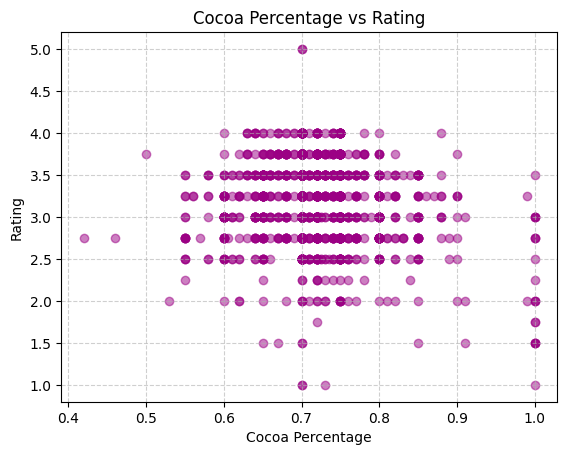

In [ ]:
plt.scatter(df['cocoa_percentage'], df['rating'], alpha=0.5, color="#9B0084")
plt.xlabel('Cocoa Percentage')
plt.ylabel('Rating')
plt.title('Cocoa Percentage vs Rating')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Видно, что большинство данных соответствуют процентному содержанию какао от 0,55 до 0,9, при этом рейтинг соответсвует значениям от 2 до 4. Данных о баточниках с процентным содержанием меньше 0,5 немного. А вот для батончиков с содержанием какао около 1 достаточно, но рейтинг при этом разбросан от 1 до 3,5. 


**Вывод:**  
* Четкой линии тренда не видно. 
* Слабая отрицательная связь говорит о том, что, высокий процент какао (около 1) иногда ассоциируется с чуть более низким рейтингом, но это не правило. 
* Плотность точек вокруг 0,7–0,75 с рейтингом 3 – 3,5 может намекать, что батончики со средним процентом какао чаще получают средние оценки.
* Разброс рейтингов при одинаковом процентном содержании говорит о том, что на рейтинг влияют другие факторы и/или их взаимодействие.  
<br>  

### 3.7 Связь года публикации обзора и других показателей <a id="year-corr"></a>  
Проанализируем, как год публикации обзора влияет на рейтинг и какие тенденции можно проследить со временем.

#### 3.7-1 Влияние года публикации обзора на рейтинг

Вновь воспользуемся однофакторным дисперсионным анализом. H₀:  
*Для каждого года рейтинг будет примерно одинаковый. Год публикации обзора на рейтинг не влияет.*

In [ ]:
years = df["review_year"].unique()
# разбиваем на группы по годам
groups = []
for year in years:
    group = df[df["review_year"] == year]["rating"] # Берем рейтинг для каждого года
    groups.append(group) # Добавляем в список

# Анализируем
f_stat, p_value = stats.f_oneway(*groups)
f"критерий Фишера: {f_stat}", f"p-value: {p_value}"

('критерий Фишера: 3.251270627282837', 'p-value: 0.00020492752425445773')

p_value < 0.05, различия значимые, отклоняем H₀ → год публикации обзора влияет на рейтинг.  
   
**Вывод:**  
Год публикации обзора влияет на рейтинг шоколадных батончиков.
  
#### 3.7-2 Изменение среднего рейтинга с годами
Изучим, как изменялся средний рейтинг шоколадных батончиков с течением времени.  
Построим график среднего значения рейтинга по годам:

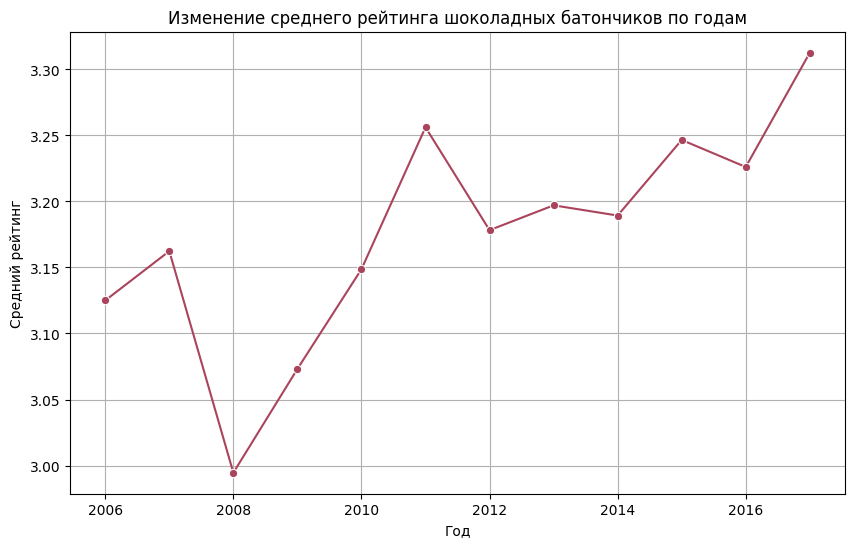

In [ ]:
# Группируем по году и считаем среднее значение рейтинга
yearly_rating = df.groupby("review_year")['rating'].mean()

# Строим график
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_rating.index, y=yearly_rating.values, marker='o', color="#A9445C")
plt.title('Изменение среднего рейтинга шоколадных батончиков по годам')
plt.xlabel('Год')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()


Видно, что с каждым годом качество шоколада растет.  

Заметен сильный спад рейтинга в 2008 году. Он может быть связан со следующими факторами:  
1. Мировой финансовый кризис (началася в 2008 г). Компании могли начать экономить, например, заменять дорогие ингредиенты на более дешёвые.   
2. Рост цен на какао из-за проблем с погодой и урожаями в странах-производителях (Кот-д’Ивуар, Гана). В рецептах могли снижать процент какао, чтобы сохранить прибыль.  

В 2011 году рейтинг шоколада слегка подскочил. Возможные причины:
1. Восстановление после кризиса. Компании могли вернуть часть прежних рецептов.  
2. Рост спроса на премиум-шоколад. В начале 2010-х начался бум на качественные продукты, органику, натуральность. Малые производители стали активнее выходить на рынок с шоколадом высокого качества.  
3. Стабилизировались урожаи какао в Западной Африке.  
  
**Вывод:**  
Рейтинг шоколадных батончиков демонстрирует общий рост с каждым годом, однако наблюдаются колебания: спад в 2008 году и резкий подъем в 2011.  
Важно исследовать возможные причины этих изменений, а также определить факторы, способствующие общему росту рейтинга.  
   

#### 3.7-3 Изменение рейтинга по годам для крупных компаний топ-9  
Причина роста среднего рейтинга с годами может быть связана с компаниями. Это, например, работа над продвижением бренда, рецептурой батончиков и пр. В этом случае в компаниях будет также наблюдаться рост среднего рейтинга с годами. Проверим, так ли это. Будем учитывать только 9 крупных компаний, производящих 20 и более различных батончиков (топ-9).  

In [ ]:
df_top_9 = df[df['company'].isin(top_9_companies)]
# Составляем таблицу рейтинга крупных компаний по годам
rating_by_year_and_company = df_top_9.groupby(['review_year', 'company'])['rating'].mean().unstack(level=0)
rating_by_year_and_company

review_year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
company,,,,,,,,,,,
A. Morin,NaN,NaN,NaN,NaN,NaN,NaN,3.62500,3.318182,3.500000,3.1875,3.750000
Arete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5000,3.557692
Bonnat,3.464286,2.500000,4.000000,2.937500,NaN,3.625000,NaN,3.375000,3.666667,NaN,3.500000
Domori,3.250000,3.656250,3.312500,NaN,3.00,3.500000,3.62500,3.000000,NaN,3.7500,NaN
Fresco,NaN,NaN,NaN,3.125000,NaN,3.250000,3.60000,3.687500,3.375000,NaN,NaN
Guittard,3.166667,3.500000,3.166667,3.166667,3.00,3.083333,NaN,3.062500,NaN,3.7500,NaN
Pralus,3.406250,4.000000,2.875000,2.000000,3.50,3.250000,NaN,NaN,NaN,3.2500,NaN
Soma,NaN,NaN,NaN,3.416667,3.75,3.583333,3.65625,3.613636,3.500000,3.7500,3.607143
Valrhona,3.200000,2.964286,NaN,3.666667,NaN,3.625000,4.00000,3.500000,NaN,4.0000,NaN


Text(158.22222222222223, 0.5, 'Средний рейтинг')

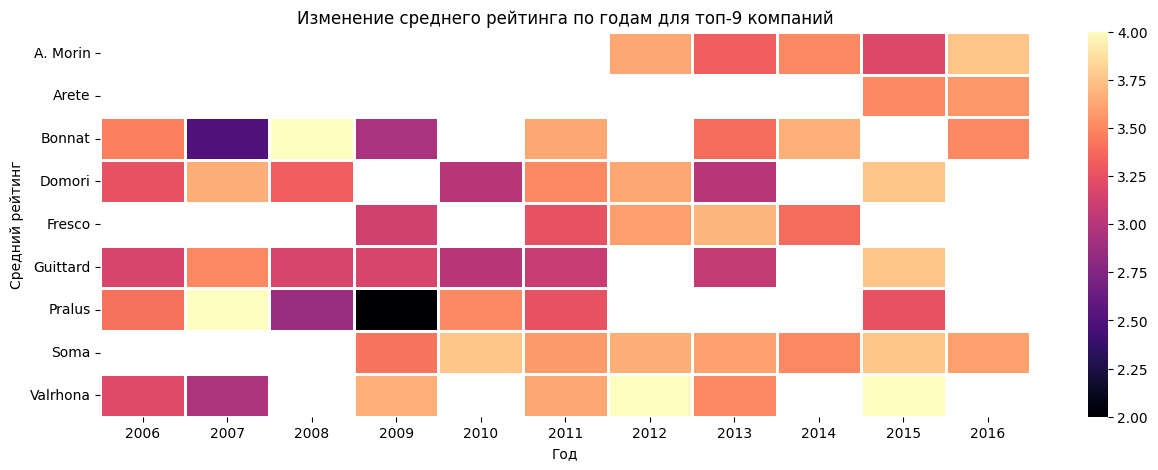

In [ ]:
# Строим тепловую карту
fig, ax = plt.subplots(figsize=[15,5])
sns.heatmap(rating_by_year_and_company, cmap='magma', linewidths=1)
ax.set_title('Изменение среднего рейтинга по годам для топ-9 компаний')
plt.xlabel('Год')
plt.ylabel('Средний рейтинг')

Средний рейтинг в различных компаниях ведет себя с годами по-разному. В общем, он демонстрирует рост, но можно выделить 3 группы, где:
1. Рейтинг шоколада с годами растет (Fresco, Valrhona, Bonnat).   
2. Рейтинг не меняется (Soma, A. Morin, Arete, Guittard).  
3. Рейтинг нестабилен (Domori, Pralus).  

**Вывод:**  
Рост среднего рейтинга с годами связан с работой внутри компании (продвижение бренда, рецептура и т.п).

#### 3.7-4 Изменение рейтинга по годам для популярных видов шоколада  
Выясним, связан ли рост рейтинга с какими-то изменениями самих видов шоколада со временем. Например, может быть модифицирована технология производства, увеличен срок хранения и пр. В этом случае тепловая карта для видов шоколада будет демонстрировать рост среднего рейтинга с годами.   
Учтем только 5 самых популярных видов шоколада.

In [ ]:
# Группируем по году и виду шоколада, считаем средний рейтинг
rating_by_year_and_species = df_pop_species.groupby(['review_year', 'species'])['rating'].mean().unstack(level=0)
# Составляем таблицу рейтинга популярных видов шоколада по годам
rating_by_year_and_species.head()

review_year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
species,,,,,,,,,,,,
Dominican Republic,NaN,3.500000,NaN,3.250,3.750000,3.333333,NaN,2.678571,3.250000,2.950000,2.937500,3.500
Ecuador,NaN,3.333333,3.0000,2.750,2.968750,3.625000,2.875000,3.250000,2.950000,3.178571,3.083333,3.375
Madagascar,4.0,3.500000,3.6875,3.225,3.250000,3.333333,3.000000,3.125000,3.295455,3.107143,3.250000,3.500
Peru,NaN,3.000000,NaN,3.000,2.500000,2.625000,2.888889,3.000000,2.821429,3.150000,2.875000,2.750
Venezuela,NaN,2.875000,3.7500,NaN,2.916667,3.250000,2.916667,2.750000,2.750000,3.250000,2.875000,3.500


Text(133.22222222222223, 0.5, 'Средний рейтинг')

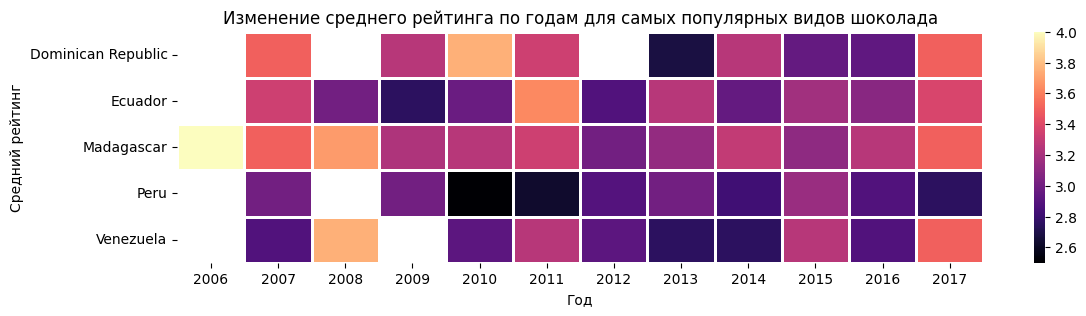

In [ ]:
# Строим тепловую карту
fig, ax = plt.subplots(figsize=[13,3])
sns.heatmap(rating_by_year_and_species, cmap='magma', linewidths=1)
plt.title('Изменение среднего рейтинга по годам для самых популярных видов шоколада')
plt.xlabel('Год')
plt.ylabel('Средний рейтинг')

Из тепловой карты видно следующее:  
* Рейтинг всех популярных видов шоколада (кроме Peru) вырос в 2017 году.    
* С 2012 по 2016 годы все популярные виды шоколада показали плохой рейтинг.  
* Peru в среднем имеет самый низкий рейтинг.  
* Для шоколада вида Madagascar с 2006 по 2012 наблюдается падение рейтинга.  
   
**Вывод:**  
Рост среднего рейтинга с годами не связан с изменением видов шоколада. 

#### 3.7-5  Изменение среднего процента содержания какао по годам       
Проанализируем, связано ли падение рейтинга в 2008 году с снижением процента какао в рецептах батончиков. Несмотря на то что корреляция между рейтингом и процентом какао отрицательная, большие изменения в составе могли повлечь за собой снижение рейтинга.

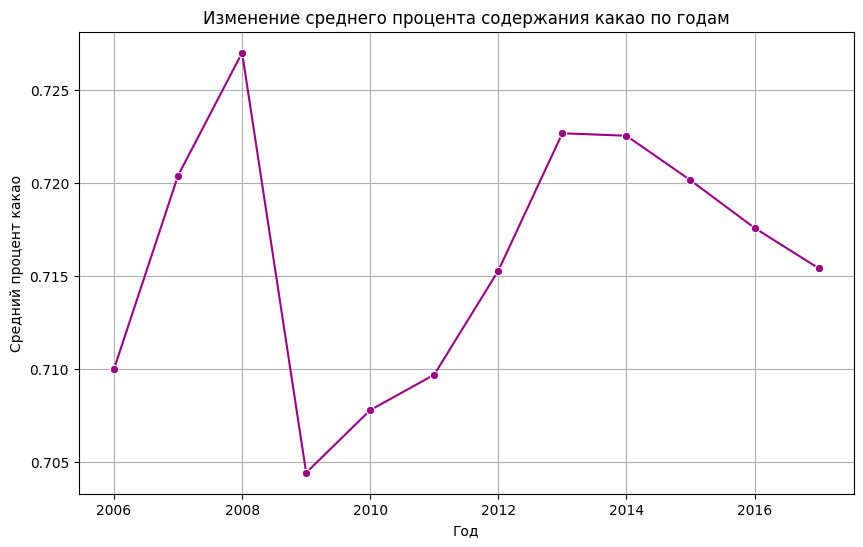

In [ ]:
# Группируем по году и считаем средний процент какао
yearly_cocoa = df.groupby("review_year")['cocoa_percentage'].mean()

# Строим график
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_cocoa.index, y=yearly_cocoa.values, marker='o', color="#9B0084")
plt.title('Изменение среднего процента содержания какао по годам')
plt.xlabel('Год')
plt.ylabel('Средний процент какао')
plt.grid(True)
plt.show()


С 2008 г. наблюдается падение процентного содержания какао батончиках.  
  
**Вывод:**  
Падение рейтинга батончиков в 2008 году связано с постепенным снижением процентного содержания какао в батончиках. Рост цен на какао и мировой финансовый кризис  - наиболее вероятные причины.

#### 3.7-6 Тенденции изменения рейтинга батончиков по годам
Ранее мы определили, что с годами средний рейтинг шоколадных батончиков растет. Еще одной причиной такого явления может быть сокращение количества батончиков с низким рейтингом или рост количества батончиков с высоким. Проверим, так ли это.  
Для начала построим точечный график, который покажет разброс значений рейтинга по годам:

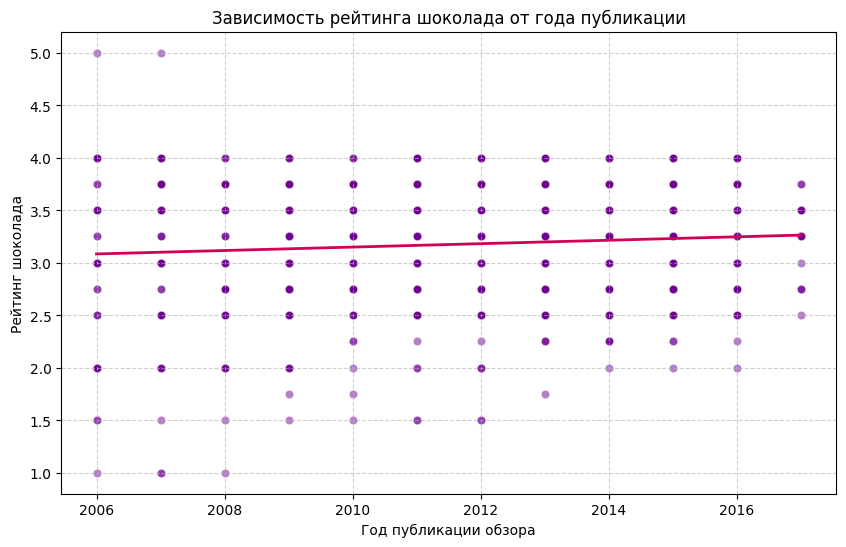

In [ ]:
# Строим точечный график
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['review_year'], y=df['rating'], alpha=0.5, color="#6D0091")
# Добавляем линию тренда
sns.regplot(x=df['review_year'], y=df['rating'], scatter=False, color="#D30057", line_kws={"linewidth": 2}, ci=None)
# Оформляем график
plt.xlabel("Год публикации обзора")
plt.ylabel("Рейтинг шоколада")
plt.title("Зависимость рейтинга шоколада от года публикации")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Низкорейтинговых шоколадок с годами становится меньше.  
Убедимся в этом, построив ящики с усами для рейтингов в каждом году:

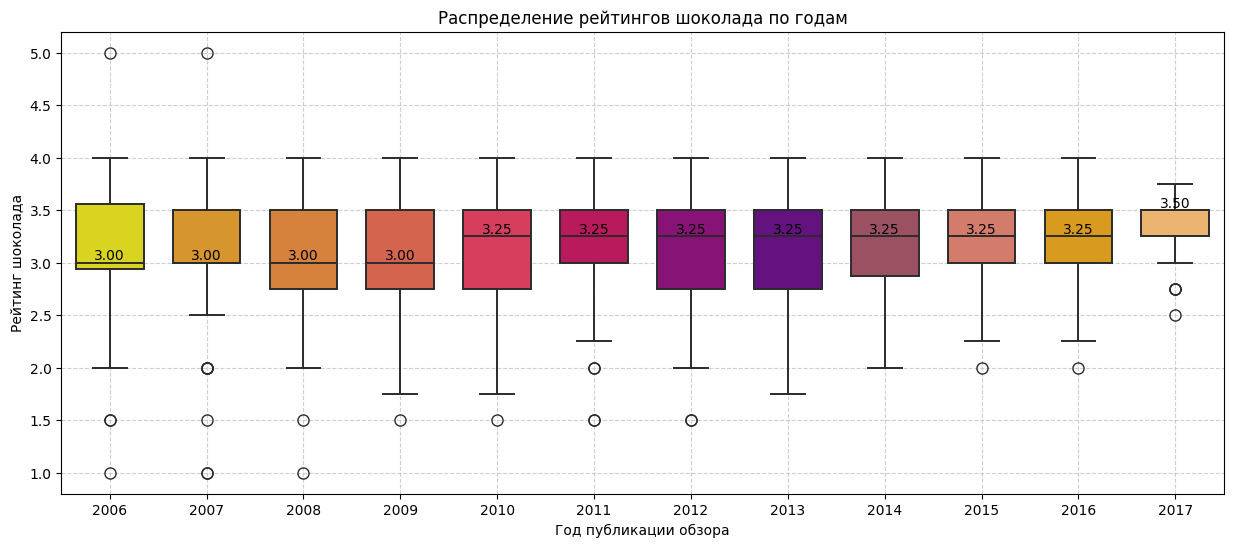

In [ ]:
# Цветовая палитра
magma_palette = [
    "#F7F100", "#F29C11", "#F07F23", "#EC5537", "#F0244E", 
    "#D30057", "#9B0084", "#6D0091", "#A9445C", "#E67059",
    "#F7A500", "#FFB75D"
]
# Строим ящики с усами
plt.figure(figsize=(15,6))
sns.boxplot(data=df, x="review_year", y="rating", palette=magma_palette, fliersize=8, linewidth=1.4, width=0.7, hue="review_year", legend=False)
plt.xlabel('Год публикации обзора')
plt.ylabel('Рейтинг шоколада')
plt.title('Распределение рейтингов шоколада по годам')
plt.grid(True, linestyle='--', alpha=0.6)
# Подписываем медианы
medians = df.groupby("review_year")["rating"].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=10, color='black')
plt.show()

Действительно, с годами становится все меньше батончиков с низким рейтингом, медианный рейтинг увеличивается. Верхняя граница рейтинга практически не меняется.  

**Вывод:**  
С годами количество шоколадных батончиков с низким рейтингом сокращается.  
<br>

### 3.8 Построение модели линейной регрессии <a id="model"></a>

Проанализируем, какие факторы и в какой степени влияют на рейтинг шоколадных батончиков. Будем использовать только те, чье влияние подтвердилось: год обзора, вид шоколада, и процентное содержание какао. Для того, чтобы исключить сильную корреляцию между факторами, построим матрицу.

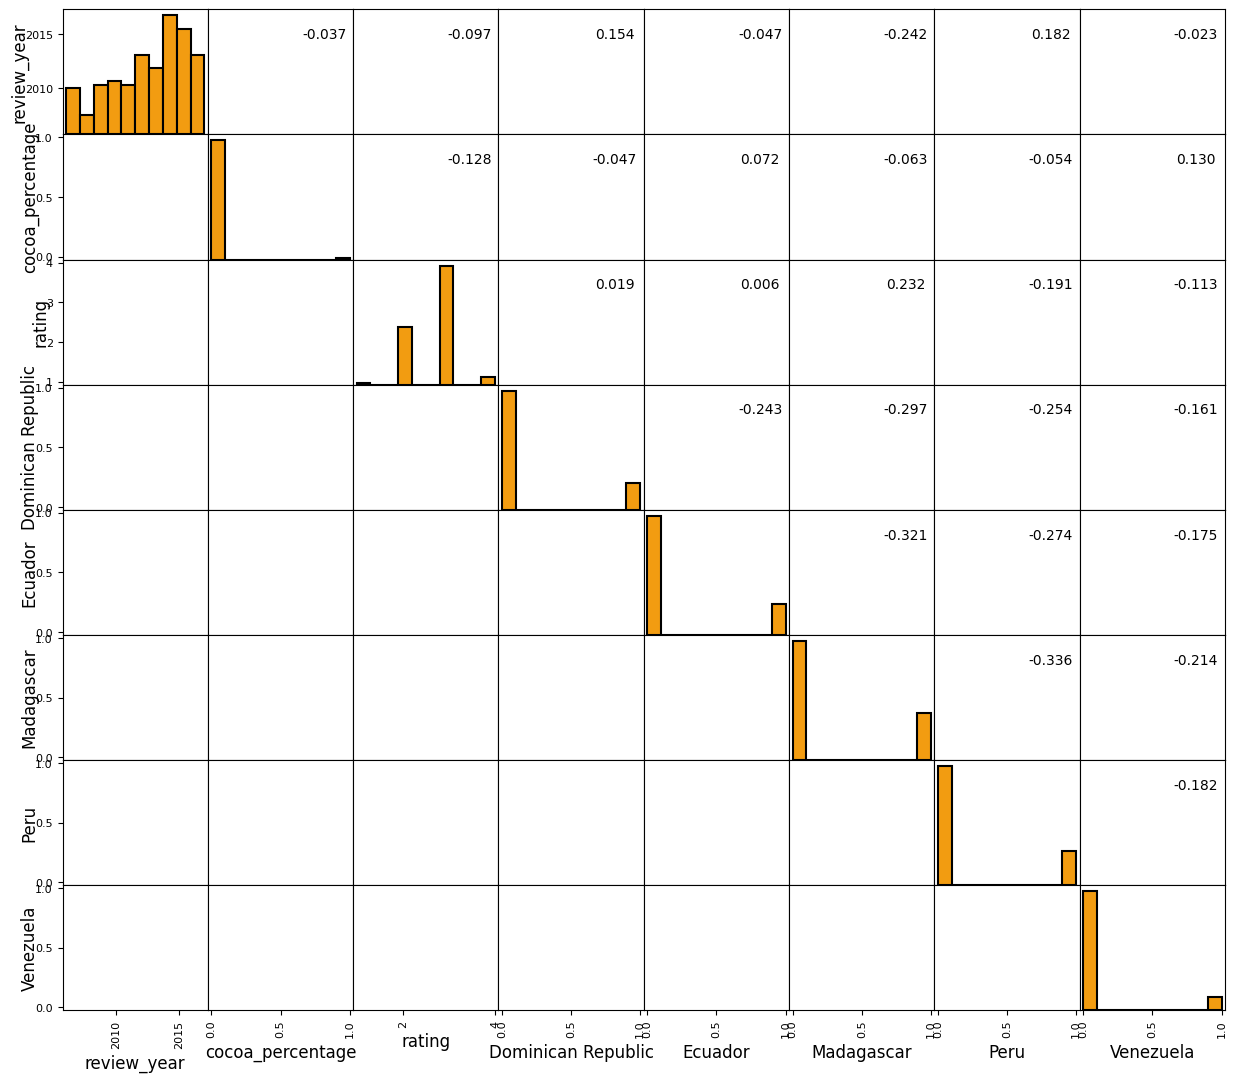

In [ ]:
# Фильтруем данные
df_filtered = df_pop_species.drop(columns = ['REF', "company_location", "bean_type", 'country', "continent", "company_cat", 'company'])
# Преобразуем категориальные переменные в One-Hot Encoding (бинарные переменные из 0 и 1)
df_encoded = pd.get_dummies(df_filtered, columns=['species'], drop_first=False)
df_encoded = df_encoded.astype(int)

# Строим матрицу
axes = pd.plotting.scatter_matrix(df_encoded, figsize=(15,13), diagonal='hist', grid=True, alpha=0, hist_kwds={'color': "#F29C11", 'edgecolor': 'black', 'linewidth': 1.5})
# Вычисляем коэффициенты корреляции
corr = df_encoded.corr().values

# Подписываем коэффициенты корреляции на графиках
for i, j in zip(*np.triu_indices_from(axes, k=1)):  
    axes[i, j].annotate("%.3f" % corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
# Убираем species_ из подписи
for ax in axes.flatten():
    xlabel = ax.get_xlabel().replace('species_', '')  
    ylabel = ax.get_ylabel().replace('species_', '') 
    ax.set_xlabel(xlabel, ha='center', fontsize=12)
    ax.set_ylabel(ylabel, va='center', fontsize=12)

plt.show()

Мультиколлинеарность отсутствует. 

In [ ]:
# Удадяем species_Dominican Republic из df_encoded, чтобы при построении регрессионной модели не было линейной зависимости. 
# Убранный вид шоколада будет учитываться в свободном члене (b0) модели.
df_encoded = df_encoded.drop(columns=['species_Dominican Republic'])

Чтобы понять, в какой степени год публикации обзора, процент какао и тип шоколада влияют на рейтинг, построим модель. 

In [ ]:
# Выделяем X и y 
# X — независимые переменные (содержание какао, год, преобразованные в нули и единицы 5 самых популярных видов шоколада)
# y — зависимая переменная (рейтинг)
y = df_encoded['rating']
X = df_encoded.drop(columns=['rating'])  

# Создаем и обучаем модель
model = LinearRegression()
model.fit(X, y)

# Выводим коэффициенты
coefficients = dict(zip(X.columns, model.coef_))
intercept = model.intercept_

print("Свободный член (intercept):", intercept)
print("Коэффициенты:")
for feature, coef in coefficients.items():
    print(f"{feature}: {coef.round(4)}")

Свободный член (intercept): 19.418222256414687
Коэффициенты:
review_year: -0.0083
cocoa_percentage: -0.6488
species_Ecuador: -0.0095
species_Madagascar: 0.1664
species_Peru: -0.2183
species_Venezuela: -0.1839


коэффициент для species_Dominican Republic — 0.  
Полученные коэффициенты показывают нам направление и степень влияния каждого из факторов.  
Чтобы понять, насколько удачна наша модель, а также какая доля изменений в рейтинге объясняется изменениями в факторах, найдем коэффициент детерминации:

In [ ]:
r2 = model.score(X, y)
print("Коэффициент детерминации R²:", r2)

Коэффициент детерминации R²: 0.09299849710064967


R² составляет 9%, что является очень маленьким значением. Это значит, что только 9% от рейтинга объясняется учтенными нами факторами, а 91% объясняется другими.   
Модель плохо описывает зависимость. На рейтинг оказывают больше влияния другие факторы, данных по которым у нас нет. Также возможно, что в данных есть шум, снижающий эффективность модели.   
Однако, из коэффициентов мы можем сделать вывод, что больше всего на рейтинг влияет процент содержания какао, причем чем он больше, тем рейтинг меньше.  
Неоднозначное влияние оказывает вид шоколада: при использовании шоколада Madagascar рейтинг растет, а в остальных случаях падает.  
Год публикации на рейтинг влияния практически не оказывает.

**Вывод:**  
На рейтинг батончиков в первую очередь влияет процент содержания какао. Разные виды шоколада оказывают разное влияние, в то время как год публикации обзора не имеет значительного эффекта.

## 4. Выводы <a id="conclusion"></a>  
1.  На рейтинг шоколадных батончиков влияют:   
* **Компания**. Рейтинги варьируются в зависимости от производителя.  ​  
* **Вид шоколада**. Например, мадагаскарский шоколад способствует повышению рейтинга, тогда как шоколад из Перу — снижению.​  
* **Год публикации обзора**. Влияет на рейтинг незначительно, однако наблюдается общая тенденция к росту рейтингов с течением времени, что связано с улучшением качества продукции и сокращением числа низкорейтинговых батончиков.​  
* **Процент содержания какао**. Наиболее значимый фактор. В целом, с увеличением содержания какао рейтинг батончиков снижается, особенно при приближении к 100%. Однако батончики со средним содержанием какао получают более стабильные оценки. Примечательно, что в 2008–2009 годах сокращение содержания какао также сопровождалось снижением рейтинга, что указывает на важность баланса. Оптимальным для высокого рейтинга является среднее содержание какао.​  

2. Около 9% изменений в рейтингах объясняются указанными факторами. Оставшиеся 91% зависят от других причин.  

3. Рекомендации для повышения рейтинга батончиков:  
* Поддерживать средний процент содержания какао.​  
* Использовать мадагаскарский вид шоколада.​  
* Уделять внимание укреплению бренда компании.  